In [61]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import datetime
import pvlib
from pvlib import location
from pvlib import solarposition, irradiance
import numpy as np


In [62]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created.")
    else:
        print(f"Folder '{folder_path}' already exists.")

In [63]:
# Define input and output paths
proyect_id = "Swiss"
file_name = "NALPS_met_1.csv"
input_path = "/Users/luis.martinez/Documents/swiss/"
output_path = "/Users/luis.martinez/Documents/swiss/output/"

full_input_path = os.path.join(input_path, file_name)
create_folder_if_not_exists(output_path)


Folder '/Users/luis.martinez/Documents/swiss/output/' already exists.


In [64]:
df = pd.read_csv(full_input_path, delimiter=',', na_values=['NA'])
# Convert the "time" column to datetime format
df["time"] = pd.to_datetime(df["time"], format="%d.%m.%Y %H:%M")

# Set the "time" column as the index
df.set_index("time", inplace=True)


In [65]:
new_column_names = {
    'TA': 'Temp_ThHyg1_degC_avg',
    'RH' : 'RH_ThHyg1_per100_avg',
    'VWND1': 'WindSpeed_Anemo1_ms_avg',
    'DWND1': 'WindDir_Wvane1_deg_avg360',
    'VWND1_MAX' : 'WindSpeed_Anemo1_ms_max',
    'HS1' : 'deep_snow',
    'time' : 'JulianTime',
    'SRAD1' :'GHI_ThPyra1_Wm-2_avg',
    'SRAD2' :'GHI_ThPyra1_Wm-2_avg_nord',
    'SRAD3' :'GHI_ThPyra1_Wm-2_avg_sud',
    'TEMP': 'Temp_ThHyg1_degC_avg',
    'WS': 'WindSpeed_Anemo1_ms_avg',
    'WD': 'WindDir_Wvane1_deg_avg360',
    'WG' : 'WindSpeed_Anemo1_ms_max',
    'GHI' :'GHI_ThPyra1_Wm-2_avg',
    'Date_Time': 'DateTime'
}
df.rename(columns=new_column_names, inplace=True)
df = df.rename_axis('JulianTime')
# Reset the index to convert it into a column
df.reset_index(inplace=True)

# Change the year for dates falling in March 2024 to 2023
#mask_2024 = (df['JulianTime'].dt.month == 3) & (df['JulianTime'].dt.year == 2024)  # Mask for March 2024 dates
#df.loc[mask_2024, 'JulianTime'] -= pd.offsets.DateOffset(years=1)  # Increment year by 1 for March 2024 dates

# Set the index back to 'JulianTime'
df.set_index('JulianTime', inplace=True)
#The data set is shifted 2 hours
df.index = df.index - datetime.timedelta(hours=2)
# Sort the DataFrame by index (dates) in ascending order
df.sort_index(inplace=True)


In [66]:
# Define the beginning and end dates (correct dates)
begin_date = '2023-03-01 00:00:00'
end_date = df.index.max()

# Define the timestamp interval in minutes
timestamp_interval = 10

# Convert begin_date to Timestamp object
begin_date = datetime.datetime.strptime(begin_date, '%Y-%m-%d %H:%M:%S')

# Now, you can perform the operations
expected_dates = [begin_date + timedelta(minutes=i*timestamp_interval) for i in range(int((end_date - begin_date).total_seconds() / 60 / timestamp_interval))]
# Find missing dates
missing_dates = [date for date in expected_dates if date not in df.index]

# Write missing dates to a text file
output_file = "missing_dates.txt"
with open(output_file, "w") as f:
    f.write("Missing Dates:\n")
    for date in missing_dates:
        f.write(date.strftime("%Y-%m-%d %H:%M") + "\n")

print(f"Missing dates saved to {output_file}")

Missing dates saved to missing_dates.txt


In [67]:
#here we will merge the both solargis data files
csv_file_1 = 'SG-98896-2312-1-1_TSmin_15.csv'
df_csv_1 = pd.read_csv(csv_file_1, sep=";", comment="#", na_values = [-9, "-9"])

df_csv_1.index = pd.DatetimeIndex(pd.to_datetime(df_csv_1["Date"] + " " + df_csv_1["Time"], format = "%d.%m.%Y %H:%M"))

csv_file_2 = 'SolarGIS_min15_1_Nalps_Tavetsch_Switzerland_20231201_20240417.csv'
df_csv_2 = pd.read_csv(csv_file_2, sep=";", comment="#", na_values = [-9, "-9"])

df_csv_2.index = pd.DatetimeIndex(pd.to_datetime(df_csv_2["Date"] + " " + df_csv_2["Time"], format = "%d.%m.%Y %H:%M"))
# Find the minimum value in the index
min_index = df_csv_1.index.min()

# Slice the DataFrame from the minimum value to '2023-11-30 23:52:00'
df_csv_11 = df_csv_1.loc[min_index:'2023-11-30 23:52:00']
df_csv = pd.concat([df_csv_11, df_csv_2])
df_csv.drop(columns=['Time', 'Date'], inplace=True)
del df_csv_1, df_csv_2, df_csv_11


In [68]:

# Rename columns
df_csv.rename(columns=new_column_names, inplace=True)


# Drop columns that are not in new_column_names
columns_to_drop = [col for col in df_csv.columns if col not in new_column_names.values()]
df_csv.drop(columns=columns_to_drop, inplace=True)

start_date = pd.to_datetime('2023-01-01', format='%Y-%m-%d')

df_csv_filtered = df_csv[df_csv.index >= start_date]

In [69]:

missing_dates_df = pd.DataFrame(index=missing_dates, columns=df_csv_filtered.columns)
missing_dates_df_1=missing_dates_df.loc['2023-03-01 00:00:00':'2023-03-03 11:50:00']


In [70]:
result = pd.concat([missing_dates_df_1, df_csv_filtered], axis=0, sort=False)
result.sort_index(inplace=True)
del missing_dates_df_1

C:\Users\luis.martinez\AppData\Local\Temp\ipykernel_2452\3438934487.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([missing_dates_df_1, df_csv_filtered], axis=0, sort=False)


In [71]:
# Convert 'GHI_ThPyra1_Wm-2_avg' column to float
result['GHI_ThPyra1_Wm-2_avg'] = result['GHI_ThPyra1_Wm-2_avg'].astype(float)

# Convert 'WindDir_Wvane1_deg_avg360' column to float
result['WindDir_Wvane1_deg_avg360'] = result['WindDir_Wvane1_deg_avg360'].astype(float)
result_interpolated = result.interpolate(method='linear', axis=0)


In [72]:

sub_df_filtered = result_interpolated.loc['2023-03-25 00:07:00':'2023-04-03 00:22:00']
sub_df = df.loc['2023-03-25 00:07:00':'2023-04-03 00:22:00']
#sub_df_filtered.index = sub_df_filtered.index + datetime.timedelta(hours=2)
#sub_df.index = sub_df.index - datetime.timedelta(hours=2)


In [73]:
#to plot with the clear sky

latitude = 46.63831041   # Latitude of the location (e.g., New York City)
longitude = 8.76790367  # Longitude of the location
altitude = 2010  # Altitude of the location (optional)
timezone = 'Etc/GMT+1'  # Timezone of the location (e.g., UTC+1 for Swiss time)

times = pd.date_range(start='2023-03-25 00:07:00', end='2023-04-03 00:22:00', freq='15min', tz=timezone)
site = location.Location(latitude, longitude, altitude=altitude, tz=timezone)
solar_position = solarposition.get_solarposition(times, latitude, longitude)
apparent_zenith = solar_position['apparent_zenith']
clearsky = site.get_clearsky(times)
ghi_clearsky = clearsky['ghi']

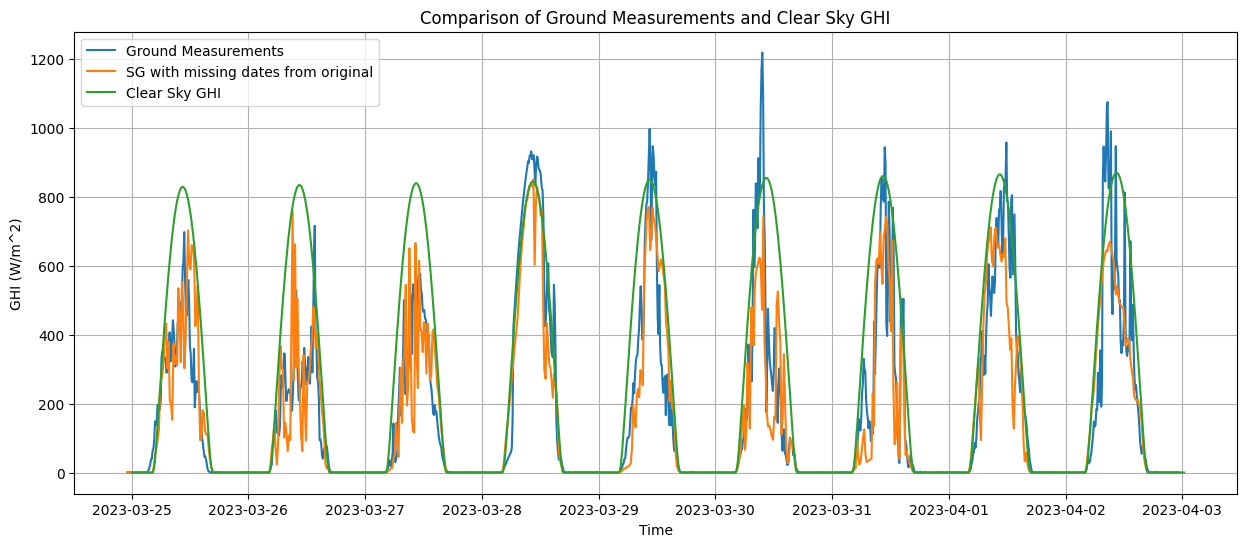

In [74]:
# Plot ground measurements and clear sky GHI
plt.figure(figsize=(15, 6))
plt.plot(sub_df.index, sub_df['GHI_ThPyra1_Wm-2_avg'], label='Ground Measurements')
plt.plot(sub_df_filtered.index, sub_df_filtered['GHI_ThPyra1_Wm-2_avg'], label='SG with missing dates from original')
plt.plot(times, ghi_clearsky, label='Clear Sky GHI')
plt.xlabel('Time')
plt.ylabel('GHI (W/m^2)')
plt.title('Comparison of Ground Measurements and Clear Sky GHI')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
missing_dates_df .columns

Index(['GHI_ThPyra1_Wm-2_avg', 'Temp_ThHyg1_degC_avg', 'RH_ThHyg1_per100_avg',
       'WindSpeed_Anemo1_ms_avg', 'WindSpeed_Anemo1_ms_max',
       'WindDir_Wvane1_deg_avg360'],
      dtype='object')

In [76]:
df.columns

Index(['Temp_ThHyg1_degC_avg', 'RH_ThHyg1_per100_avg', 'GHI_ThPyra1_Wm-2_avg',
       'GHI_ThPyra1_Wm-2_avg_nord', 'GHI_ThPyra1_Wm-2_avg_sud',
       'WindSpeed_Anemo1_ms_avg', 'WindDir_Wvane1_deg_avg360',
       'WindSpeed_Anemo1_ms_max', 'deep_snow'],
      dtype='object')

In [77]:

# Convert the string representation to a datetime object
threshold_date = pd.to_datetime('2023-03-03 11:50')

for column in result_interpolated.columns:
    for date in missing_dates:
        if date <= threshold_date:
            missing_dates_df.loc[date, column] = result_interpolated.loc[date, column]
del result_interpolated

In [82]:
missing_dates_df['deep_snow'] =  np.nan 
missing_dates_df['GHI_ThPyra1_Wm-2_avg_sud'] =  np.nan 
missing_dates_df['GHI_ThPyra1_Wm-2_avg_nord'] =  np.nan 

In [84]:
final_df = pd.concat([missing_dates_df, df], axis=0, sort=False)
final_df.sort_index(inplace=True)

In [87]:

final_df = final_df.rename_axis('JulianTime')
final_df

,GHI_ThPyra1_Wm-2_avg,Temp_ThHyg1_degC_avg,RH_ThHyg1_per100_avg,WindSpeed_Anemo1_ms_avg,WindSpeed_Anemo1_ms_max,WindDir_Wvane1_deg_avg360,deep_snow,GHI_ThPyra1_Wm-2_avg_sud,GHI_ThPyra1_Wm-2_avg_nord
JulianTime,,,,,,,,,
2023-03-01 00:00:00,0.0,-10.85,80.15,0.2,3.9,237.0,NaN,NaN,NaN
2023-03-01 00:10:00,0.0,-11.1,79.833333,0.2,3.9,214.0,NaN,NaN,NaN
2023-03-01 00:20:00,0.0,-11.1,79.766667,0.2,3.9,212.0,NaN,NaN,NaN
2023-03-01 00:30:00,0.0,-11.1,79.6,0.2,3.9,208.5,NaN,NaN,NaN
2023-03-01 00:40:00,0.0,-11.033333,79.433333,0.233333,3.933333,206.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-04-23 11:00:00,628.1,-4.724,84.9,4.361,9.3,13.02,85.80,663.5,510.8
2024-04-23 11:10:00,683.0,-5.368,88.2,4.203,8.1,1.775,69.34,730.5,523.9
2024-04-23 11:20:00,642.7,-5.72,89.7,4.06,5.6,353.2,59.34,653.5,504.5


In [88]:
#save the dataframe
final_df.to_csv(output_path+'CH_Basler.csv')